In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *
from ct_tracking_library.ct_fk_functions import *

#used for GUI
%matplotlib notebook

#find transform
import datetime
import time
import pickle
from spatialmath import *
from roboticstoolbox import ET as E
import transforms3d as t3d

In [ ]:
#SETUP
#home the robot and find zero position in mm
#SETUP DATA DIRECTORIES FOR THE TEST DAY

In [ ]:
#MULTIPLE SCANS STEPS TO RUN BELOW:
#1. run robot to user specified position (mm) and store actual posiiton (mm) robot object for each scans

In [2]:
async def run_motor(c,ip,d1=None,d2=None,old_uds=None):
    """
    This function let user inputs a postion in mm and save the motor joint postion in the input list:

    Args:
        c: the moteus motor object.
        ip(float): intial rev postion value for the motor.

    Returns:
        robot: robot object that stores postion in mm

    """
    ratio = 0.5040628051757813 #converting mm to rev
    uds = int(input('Enter the desired postion in mm (0-127): '))
    if old_uds is not None:
        if uds >= old_uds:
            currcent_p_list,p_mm = await one_axis_farward(c,ip,user_desried=uds*ratio)
        else:
            currcent_p_list,p_mm = await one_axis_backward(c,ip,user_desried=uds*ratio)
    else:
        currcent_p_list,p_mm = await one_axis_farward(c,ip,user_desried=uds*ratio)
    p_mm = p_mm/ratio
    return Robot(m=ratio,joint_postion=p_mm,set_point=uds,d1=d1,d2=d2,zero=ip)

In [3]:
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    """
    This function is a helper function that helps the drop dwon list for DICOM file in folder:

    Args:
        series_to_load(list): list of the DICOM serial number in the folder.
        series_dictionary(dict): dict that holds the dicm files.

    """
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load

In [4]:
def get_marker(selected_series,time,v = False, debug = False):
    """
    This function finds the marker from the user sleceted dicom file:

    Args:
        selected_series(string): the serial key for the slected DICOM.
        time(Time): time intial when the function is called.
        v(bool): to show visualization for the marker
        debug(bool): wheather or not the user want to see debug info.

    Returns:
        M_list[0](Marker): the moveing marker object finded
        M_list[1](Marker): the fixed marker object finded
        v_mesh(Open3d mesh): the mesh used for finding the marker in form of open3d

    """
    M_list = []
    for S in range(2):
        # pick marker
        if S == 0:
            target_marker_name = 'moving_marker_1_DoF'
            marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
            R = np.eye(3)
            crop_z = None
        else:
            target_marker_name = 'fixed_marker_1_DoF'
            marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
            R = np.eye(3)
            crop_z = [160,254]

        #convert scan to mesh for finding markers via thresholding
        scan_file = series_file_names[selected_series]
        convert_scan_to_mha(scan_file, crop_z = crop_z)
        convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

        #find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
        _, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=debug)
        if debug:
            print('marker centroid coordinates from design: {}'.format(marker))
            print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

        #display candidate fiducials
        if v:
            o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

        #find best transform and marker from candidate fiducials
        tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

        #get rid of column of ones to make 3xN
        permuted_centroids = permuted_centroids[:3,:].T

        #transform marker geometry coordinates using found transform to tracked image coordinates
        transformed_marker = (tracked_R @ marker.T + tracked_t).T
        error = permuted_centroids-transformed_marker
        
        #tracking error from final transform
        np.set_printoptions(2)
        print("Error (mm): {}".format(error))
        print("Error norm (mm): {}".format(np.linalg.norm(error)**0.5))
        if v:
            #create o3d visualizations
            marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
            marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
            marker_3d_base.append(create_coordinate_frame_visualization())
            marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
            marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))
            #visualize tracked markers on top of mesh used for tracking
            visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
            visualization_list1 = copy.deepcopy(visualization_list2)
            o3d.visualization.draw_geometries(visualization_list2)
        if S == 0:
            v_mesh= marker_mesh
        #append marker
        M_list.append(Marker(name=target_marker_name,d_key=selected_series,time =time,geometry=marker,T=t2T(tracked_R, tracked_t/1000),error=np.linalg.norm(error)**0.5))
        
    return M_list[0],M_list[1],v_mesh

## Setup the Motor

User input: millimeters (because thats easier to think about than meters)
Motor motions: radians, radian/s, etc. (because thats is an SI type unit)
Actuator motions: millimeters (because thats an SI type unit)
Transforms: radians and millimeters because thats always pretty much they use

In [ ]:
c = moteus.Controller() # created moteus motor object

# Robot self-test
#### Run the code below to check the motor and zeroing method are fully functional

In [ ]:
n = input('Enter the number of loop')
d1,d2 = await stopping_acc_test(c,int(n))

## Start the CT Tracking Test

In [7]:
#SETUP DATA DIRECTORIES FOR THE TEST DAY
data = {}
s_num = 0

### Home the robot and find zero position in mm

In [ ]:
ip = await motor_zero(c,stop_torque=.1,v=1)
# python -m moteus_gui.tview --devices=1
# await read_p()

### Once get the intial starting postion(ip), run the function with the desired postion, and then run the CT scanner once motor moved.

## Run the code if this the first time runing

In [ ]:
robot,old_postion = await run_motor(c,ip,d1,d2)

### for the rest of loop, run the following code

In [ ]:
robot,old_postion = await run_motor(c,ip,d1,d2,old_postion)

## Feltch the DICOM file from server
### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient
### Selected Series on the top tabs
### On the left hand side input: DIMITRI07041995 as the Patient ID
### In the middle section select Newest Frist in the Order by Tab
### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit
### Download the 1st row by clicking the 3 dots symbol and downolad it
### Once Downloaded, extract the DICOM files ONLY to the following folder: ./test_data/DICOM

In [8]:
#2. download CT scan from server and load into python by selecting from drop down menu
# question: can the menu sort by time to display the newest scan first?


data_directory = "./test_data/DICOM"
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()    
# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    
    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.416.148220411494716321…

In [10]:
#3. process selected CT scan into two marker objects and print reprojection tracking error and warning if high
time = datetime.datetime.now()
time = time.strftime("%m/%d/%y %I:%M%p")
marker1,marker2,mesh = get_marker(selected_series,time)

spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=34
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 109.95it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 6 7]
[2 3 4 5]
[0.05 5.91]
Everything looks good!
the final error is:  0.04597412046734961
Error (mm): [[ 0.03 -0.01  0.01]
 [-0.05 -0.02 -0.  ]
 [ 0.04 -0.01 -0.01]
 [-0.02  0.04  0.01]]
Error norm (mm): 0.3032296834656845


spacing:  [0.63 0.7  0.7 ]
 origin:  [ -49.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=33
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 97.59it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 5 6]
[1 2 3 4]
[0.15]
Everything looks good!
the final error is:  0.15252497903498627
Error (mm): [[-0.09 -0.14  0.02]
 [ 0.13 -0.04 -0.03]
 [-0.04  0.2  -0.01]
 [ 0.   -0.01  0.03]]
Error norm (mm): 0.5523132789187424


In [11]:
### DELETE after this test ###
with open('data2.pkl', 'rb') as f:
    data_load = pickle.load(f)
data_load['scan0'][2].zero_postion = data_load['scan0'][2].joint_postion
data_load['scan1'][2].zero_postion = data_load['scan0'][2].zero_postion

In [12]:
#5. calculate forward kinematics of joint position and error between and FK and tracking
fk,r_error,p_error = find_fk(marker1,marker2,data_load['scan1'][2])
#fk,r_error,p_error = find_fk(marker1,marker2,robot)
#6. display forward kinematics transforms + tracked marker transforms in open3D AND print errors with warnings
display_fk(fk,marker1,mesh)

Postion Error norm(mm):  0.0005589428246891441
Rotional Error norm(Euler Angle):  [ 3.85  1.55 -2.32]


In [ ]:
#7. save everything to data directory w/ timestamp for this loop IF good for this loop to dictionary
append_value(data, "scan"+str(s_num), marker1)
append_value(data, "scan"+str(s_num), marker2)
append_value(data, "scan"+str(s_num), Robot(time,robot.m,robot.joint_postion,robot.set_point, robot.STD_f,robot.STD_b))
#8. save to temporary pickle file for this test every loop incase the software crashes
d_name = 'temp_data'+str(s_num)+'.pkl'
with open(d_name, 'wb') as f:
    pickle.dump(data, f)
s_num += 1

In [ ]:
#8. save to pickle file for final test data
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)
#await read_p()

## Self Test

In [18]:
P_list = []
with open('data2.pkl', 'rb') as f:
    data_load = pickle.load(f)
data_load['scan0'][2].zero_postion = data_load['scan0'][2].joint_postion
data_load['scan1'][2].zero_postion = data_load['scan0'][2].zero_postion
data_load['scan2'][2].zero_postion = data_load['scan0'][2].zero_postion
data_load['scan3'][2].zero_postion = data_load['scan0'][2].zero_postion
data_load['scan4'][2].zero_postion = data_load['scan0'][2].zero_postion
data_load['scan5'][2].zero_postion = data_load['scan0'][2].zero_postion
data_load['scan6'][2].zero_postion = data_load['scan0'][2].zero_postion
for x in data_load:
    _,_,p_error = find_fk(data_load[x][0],data_load[x][1],data_load[x][2])
    P_list.append(np.linalg.norm(p_error))

<IPython.core.display.Javascript object>


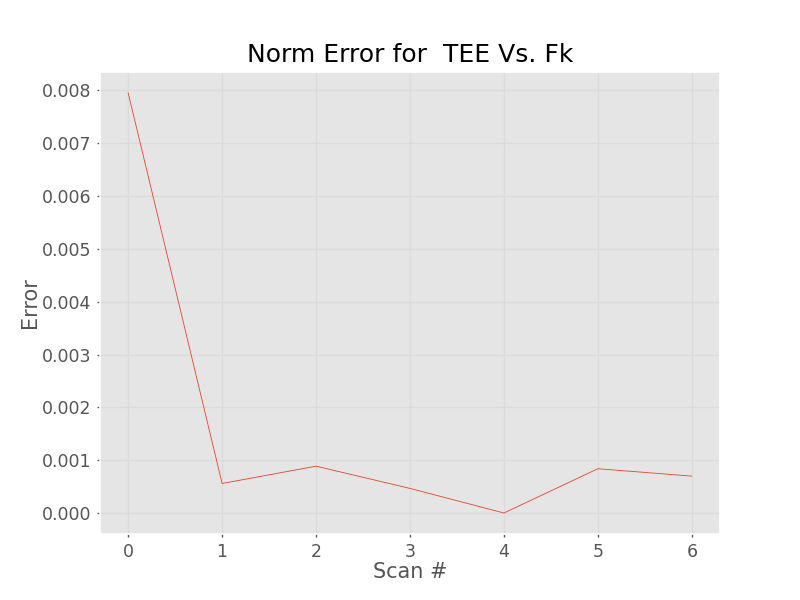

Text(0.5, 0, 'Scan #')

In [24]:
plt.plot(P_list)
plt.title("Norm Error for  TEE Vs. Fk")
plt.ylabel("Error")
plt.xlabel("Scan #")